# Описание

Необходимо сократить число цветов в палитре изображения. Картинку для выполнения работы можно выбрать любую, главное условие – наличие на ней разных цветов, для того, чтобы результат работы моделей был заметен.
Для выполнения работы необходимо выделить кластеры в пространстве RGB, объекты соответствуют пикселям изображения. После выделения кластеров все пиксели, отнесенные в один кластер, заполняются одним цветом. Цвет – центроид соответствующего кластера.

## Импорт библиотек

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans

## Этап 1. Получение и загрузка данных

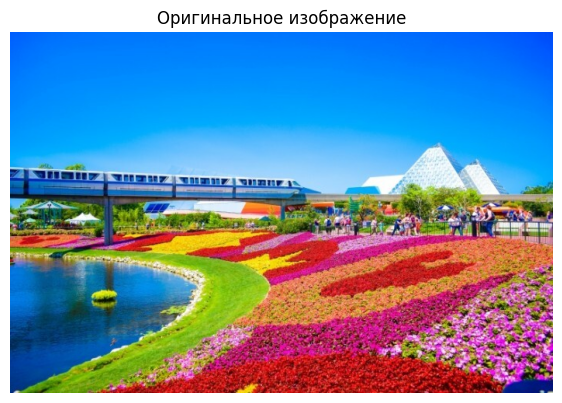

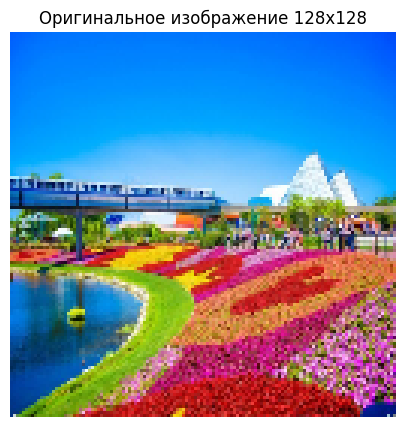

In [2]:
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image)  # cv2 отдает цвета в порядке BGR
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis("off")
    plt.imshow(new_image)
    plt.title(title)
    plt.show()


path = "../data/images/image.jpg"
img = cv2.imread(path)
draw_picture(img, "Оригинальное изображение")
img = cv2.resize(img, (128, 128))
draw_picture(img, "Оригинальное изображение 128х128")

## Реализация 3-х моделей кластеризации:

### KMeans

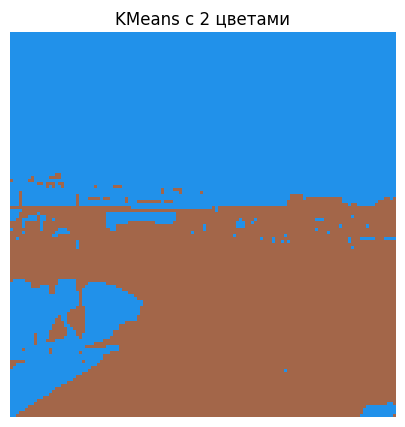

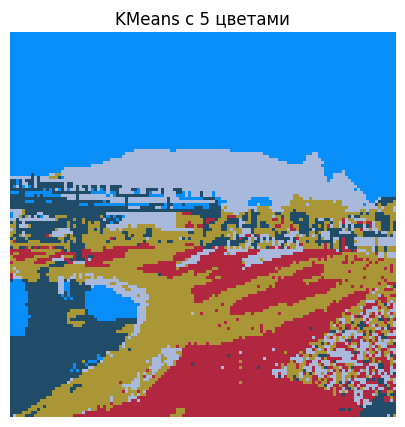

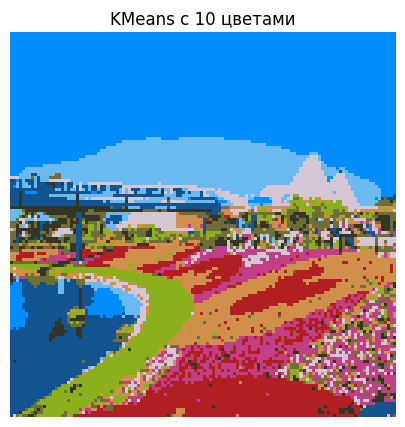

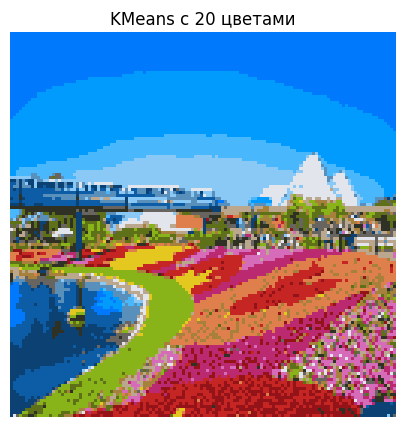

In [3]:
def apply_kmeans(image, n_clusters):
    pixels = image.reshape(-1, 3)  # Переводим в 2D массив (пиксели, цвета)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pixels)
    quantized = kmeans.cluster_centers_[kmeans.labels_]
    return quantized.reshape(image.shape).astype(np.uint8)


for k in [2, 5, 10, 20]:
    quantized_img = apply_kmeans(img, k)
    draw_picture(quantized_img, f"KMeans с {k} цветами")

### DBSCAN

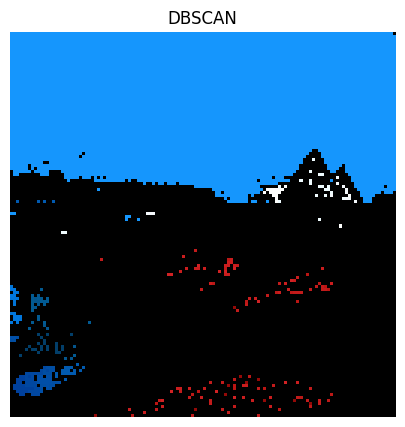

In [4]:
def apply_dbscan(image, eps=3, min_samples=10):
    # Преобразование изображения в массив пикселей (размерность: количество пикселей, 3 канала цвета)
    pixels = image.reshape(-1, 3)

    # Инициализация алгоритма DBSCAN с заданными параметрами
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Применение алгоритма DBSCAN для кластеризации пикселей
    labels = dbscan.fit_predict(pixels)

    # Получение уникальных меток кластеров
    unique_labels = np.unique(labels)

    # Создание массива для хранения квантованных пикселей
    quantized = np.zeros_like(pixels)

    # Обработка каждого уникального кластера
    for label in unique_labels:
        if label != -1:  # Пропускаем шум (метка -1)
            # Для каждого кластера устанавливаем цвет как среднее значение пикселей в этом кластере
            quantized[labels == label] = pixels[labels == label].mean(axis=0)

    # Преобразование массива квантованных пикселей обратно в форму изображения и приведение типа к uint8
    return quantized.reshape(image.shape).astype(np.uint8)


dbscan_img = apply_dbscan(img)
draw_picture(dbscan_img, "DBSCAN")

### AgglomerativeClustering

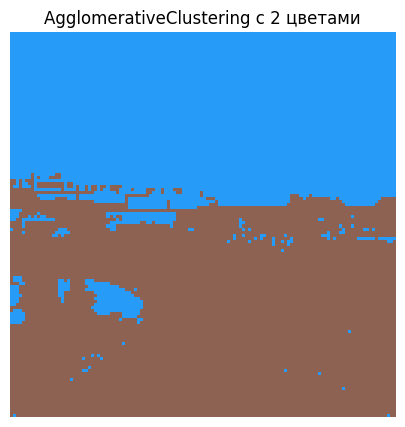

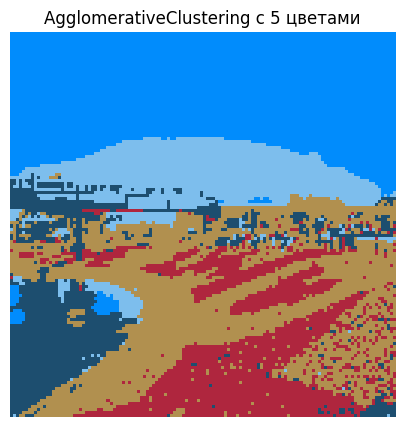

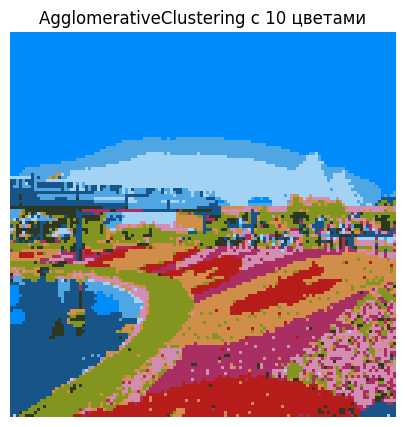

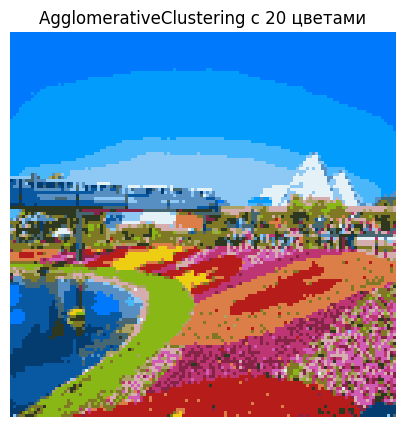

In [5]:
def apply_agglomerative(image, n_clusters):
    # Преобразование изображения в массив пикселей (размерность: количество пикселей, 3 канала цвета)
    pixels = image.reshape(-1, 3)

    # Инициализация алгоритма агломеративной кластеризации с заданным количеством кластеров
    model = AgglomerativeClustering(n_clusters=n_clusters)

    # Применение алгоритма для кластеризации пикселей
    labels = model.fit_predict(pixels)

    # Создание массива для хранения квантованных пикселей
    quantized = np.zeros_like(pixels)

    # Обработка каждого кластера и назначение цветового значения
    for i in range(n_clusters):
        # Устанавливаем цвет кластера как среднее значение пикселей в этом кластере
        quantized[labels == i] = pixels[labels == i].mean(axis=0)

    # Преобразование массива квантованных пикселей обратно в форму изображения и приведение типа к uint8
    return quantized.reshape(image.shape).astype(np.uint8)


for k in [2, 5, 10, 20]:
    agglomerative_img = apply_agglomerative(img, k)
    draw_picture(agglomerative_img, f"AgglomerativeClustering с {k} цветами")

## Этап 3. Оценка потери от уменьшения цветов при помощи метрики SSIM

In [6]:
def calculate_ssim(original, compressed):
    # Преобразуем оригинальное и сжатое изображения в оттенки серого
    original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    compressed_gray = cv2.cvtColor(compressed, cv2.COLOR_BGR2GRAY)

    # Вычисляем индекс структурного сходства (SSIM)
    return ssim(original_gray, compressed_gray)


# Выводим оценки SSIM
print("SSIM Scores:")
for k in [2, 5, 10, 20]:
    # Применяем алгоритм KMeans для выставленного количества кластеров
    kmeans_img = apply_kmeans(img, k)

    # Вычисляем и выводим SSIM для изображения после KMeans
    score = calculate_ssim(img, kmeans_img)
    print(f"KMeans с {k} цветами: SSIM = {score}")

# Вычисляем и выводим SSIM для изображения, полученного с помощью DBSCAN
dbscan_score = calculate_ssim(img, dbscan_img)
print(f"DBSCAN: SSIM = {dbscan_score}")

for k in [2, 5, 10, 20]:
    # Применяем агломеративную кластеризацию для выставленного количества кластеров
    agglomerative_img = apply_agglomerative(img, k)

    # Вычисляем и выводим SSIM для изображения после агломеративной кластеризации
    score = calculate_ssim(img, agglomerative_img)
    print(f"Агломеративная кластеризация с {k} цветами: SSIM = {score}")

SSIM Scores:
KMeans с 2 цветами: SSIM = 0.3480038665686382
KMeans с 5 цветами: SSIM = 0.7394745850523587
KMeans с 10 цветами: SSIM = 0.8020453092488617
KMeans с 20 цветами: SSIM = 0.8583365609227348
DBSCAN: SSIM = 0.28086619329207396
Агломеративная кластеризация с 2 цветами: SSIM = 0.3793412502083906
Агломеративная кластеризация с 5 цветами: SSIM = 0.69625805153874
Агломеративная кластеризация с 10 цветами: SSIM = 0.7825444361520214
Агломеративная кластеризация с 20 цветами: SSIM = 0.83257481750202


# Сравнительный анализ методов кластеризации

## 1. Сравнение методов и количества цветов

- **KMeans**:
  - 2 цвета: SSIM = 0.3478
  - 5 цветов: SSIM = 0.7395
  - 10 цветов: SSIM = 0.8021
  - <u>20 цветов: SSIM = 0.8572 (лучший результат)</u>

- **DBSCAN**:
  - <u>SSIM = 0.2809 (худший результат)</u>

- **Agglomerative Clustering**:
  - 2 цвета: SSIM = 0.3793
  - 5 цветов: SSIM = 0.6963
  - 10 цветов: SSIM = 0.7825
  - 20 цветов: SSIM = 0.8326

## 2. Выводы

1. **Наилучший результат**:
   - **KMeans с 20 цветами** показывает наивысший SSIM (0.8572), что указывает на лучшее сохранение структурной информации изображения при данной кластеризации. Это значит, что при использовании 20 цветов KMeans максимально близок к оригинальному изображению по визуальному восприятию.

2. **Сравнение с другими методами**:
   - Хотя KMeans показывает наилучшие результаты среди остальных экспериментов, **Agglomerative Clustering** также демонстрирует хорошие результаты, особенно с увеличением числа кластеров. SSIM для 20 цветов составляет 0.8326, что достаточно близко к результату KMeans.
   - **DBSCAN** оказался менее эффективным, получив наименьший показатель SSIM (0.2809), что означает значительное искажение структуры изображения.

3. **Зависимость от числа цветов**:
   - При росте количества кластеров для обоих методов (KMeans и Agglomerative Clustering) наблюдается улучшение показателей SSIM, что подчеркивает важность выбора оптимального числа цветов для сохранения качества изображения.
   - Для KMeans увеличение числа цветов с 2 до 20 значительно улучшает качество (от 0.3478 до 0.8572), в то время как для Agglomerative Clustering аналогичное улучшение составляет от 0.3793 до 0.8326.

## 3. Рекомендации
- Если целью является максимальное качество и близость к оригиналу, рекомендуется использовать KMeans с 20 цветами.
- Для случаев, когда возможна потеря в качестве или ресурсы ограничены, KMeans с 10 цветами также демонстрирует приличное качество и может использоваться как компромисс.
- Для задач, где необходимо использовать кластеризацию, но критично качество, следует избегать DBSCAN без дополнительной настройки параметров.